/home/group07/anaconda3/envs/pytorch_env2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../out_of_context/im017.jpg


/home/group07/anaconda3/envs/pytorch_env2/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/group07/anaconda3/envs/pytorch_env2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Boxes(tensor([[ 91.7209,  50.5286, 242.2783, 205.9693],
        [ 23.3016,  77.2325,  60.5778, 141.9331],
        [240.7621,  30.5236, 377.6556, 175.3726],
        [125.5144,  79.3041, 256.4028, 216.7213],
        [178.7143,  86.4271, 195.8670, 121.7090],
        [246.1507,  34.0897, 380.0000, 179.7161]]))


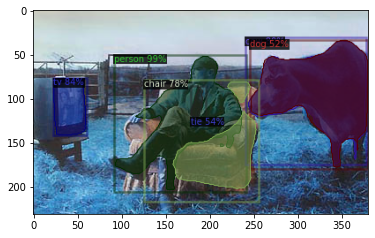

In [2]:
import os


import cv2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib.pyplot import imshow
import numpy as np


MODEL_NAME = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
RESULT_DIR = 'results'
DATA_PATH = '../out_of_context'

if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

setup_logger()
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(MODEL_NAME))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_NAME)
predictor = DefaultPredictor(cfg)

for image in os.listdir(DATA_PATH)[2:5]:
    img_path = os.path.join(DATA_PATH, image)
    print(img_path)
    output_path = os.path.join(RESULT_DIR, image)
    
    # Read image
    im = cv2.imread(img_path)
    
    # Forward pass
    outputs = predictor(im)

    # Save to disk
    v = Visualizer(
        im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(img.get_image()[:, :, ::-1])
    mask= outputs['instances'].get('pred_boxes')
    mask= mask.to('cpu')
    print(mask)
    break

244 377 34 173


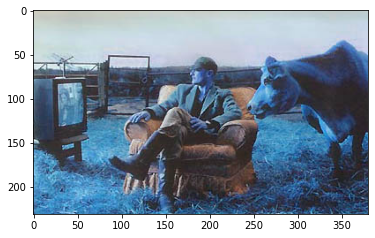

In [20]:
from PIL import Image
# Get the masks
masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))

# Pick an item to mask
item_mask = masks[2]

# Get the true bounding box of the mask (not the same as the bbox prediction)
segmentation = np.where(item_mask == True)
x_min = int(np.min(segmentation[1]))
x_max = int(np.max(segmentation[1]))
y_min = int(np.min(segmentation[0]))
y_max = int(np.max(segmentation[0]))
print(x_min, x_max, y_min, y_max)

# Create a cropped image from just the portion of the image we want
cropped = Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')

# Create a PIL image out of the mask
mask = Image.fromarray((item_mask * 255).astype('uint8'))

# Crop the mask to match the cropped image
cropped_mask = mask.crop((x_min, y_min, x_max, y_max))

# Load in a background image and choose a paste position
background = Image.fromarray(im, mode='RGB')
paste_position = (0, 0)

# Create a new foreground image as large as the composite and paste the cropped image on top
new_fg_image = Image.new('RGB', background.size)
new_fg_image.paste(cropped, paste_position)

# Create a new alpha mask as large as the composite and paste the cropped mask
new_alpha_mask = Image.new('L', background.size, color = 0)
new_alpha_mask.paste(cropped_mask, paste_position)

# Compose the foreground and background using the alpha mask
composite = Image.composite(new_fg_image, background, new_alpha_mask)

# Display the image
imshow(np.array(cropped))

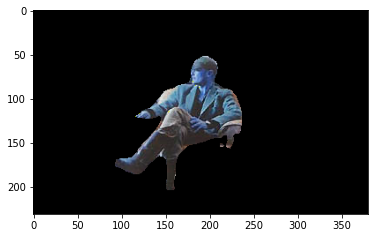

In [27]:
mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
num_instances = 1#mask_array.shape[0]
scores = outputs['instances'].scores.to("cpu").numpy()
labels = outputs['instances'].pred_classes .to("cpu").numpy()
bbox   = outputs['instances'].pred_boxes.to("cpu").tensor.numpy()

mask_array = np.moveaxis(mask_array, 0, -1)

mask_array_instance = []
#img = np.zeros_like(im) #black
h = im.shape[0]
w = im.shape[1]
img_mask = np.zeros([h, w, 3], np.uint8)
color = (200, 100, 255)
for i in range(num_instances):
    img = np.zeros_like(im)
    mask_array_instance.append(mask_array[:, :, i:(i+1)])
    img = np.where(mask_array_instance[i] == True, 255, img)
    array_img = np.asarray(img)
    img_mask[np.where((array_img==[255,255,255]).all(axis=2))]=color
    
img_mask = np.asarray(img_mask)
gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

masked = cv2.bitwise_and(im,im,mask = thresh)
masked[thresh==0] = [255,255,255] # Turn background white
#output = cv2.addWeighted(im, 0.7, img_mask, 0.3, 0)
imshow(np.array(im-masked))